# [第4回 今更だけど基礎から強化学習を勉強する 連続行動空間編](https://qiita.com/pocokhc/items/0872539ad9d981847595)

In [1]:
from gym import spaces
from gym.envs.classic_control.cartpole import CartPoleEnv
import numpy as np
import math
import tensorflow as tf
from tensorflow.python import keras
from tensorflow.keras.optimizers import Adam
from matplotlib import pyplot as plt

2022-06-29 01:10:45.590764: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/sonoda/.pyenv/versions/3.9.6/lib/python3.9/site-packages/cv2/../../lib64:
2022-06-29 01:10:45.590782: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## 行動空間を連続値にしたCartPole

In [2]:
# オリジナルのCartpoleを継承
class MyCartpole(CartPoleEnv):
    def __init__(self):
        super().__init__()

        # action_space を連続空間に変更
        self.action_space = spaces.Box(-self.force_mag, self.force_mag, shape=(1,), dtype=np.float32)

    def reset(self):
        # 終了ターンのが実装内で定義されているので実装
        self.step_count = 0
        return super().reset()

    def step(self, action):
        # デバッグ
#         print(self.state, action)
        # 200ターンたったら終了する
        self.step_count += 1
        if self.step_count > 200:
            return np.array(self.state), 0.0, True, {}
        
        # 例外処理
#         print(action)
        if np.isnan(action):
            return np.array(self.state), 0.0, True, {}
        
        # アクションをclipして force の値にする
        force = np.clip(action, -self.force_mag, self.force_mag)[0]

        #--- 以下オリジナルのstepコードをコピペ ---

        x, x_dot, theta, theta_dot = self.state
        costheta = math.cos(theta)
        sintheta = math.sin(theta)

        # For the interested reader:
        # https://coneural.org/florian/papers/05_cart_pole.pdf
        temp = (force + self.polemass_length * theta_dot ** 2 * sintheta) / self.total_mass
        thetaacc = (self.gravity * sintheta - costheta * temp) / (self.length * (4.0 / 3.0 - self.masspole * costheta ** 2 / self.total_mass))
        xacc = temp - self.polemass_length * thetaacc * costheta / self.total_mass

        if self.kinematics_integrator == 'euler':
            x = x + self.tau * x_dot
            x_dot = x_dot + self.tau * xacc
            theta = theta + self.tau * theta_dot
            theta_dot = theta_dot + self.tau * thetaacc
        else:  # semi-implicit euler
            x_dot = x_dot + self.tau * xacc
            x = x + self.tau * x_dot
            theta_dot = theta_dot + self.tau * thetaacc
            theta = theta + self.tau * theta_dot

        self.state = (x, x_dot, theta, theta_dot)

        done = bool(
            x < -self.x_threshold
            or x > self.x_threshold
            or theta < -self.theta_threshold_radians
            or theta > self.theta_threshold_radians
        )

        if not done:
            reward = 1.0
        elif self.steps_beyond_done is None:
            # Pole just fell!
            self.steps_beyond_done = 0
            reward = 1.0
        else:
            if self.steps_beyond_done == 0:
                logger.warn(
                    "You are calling 'step()' even though this "
                    "environment has already returned done = True. You "
                    "should always call 'reset()' once you receive 'done = "
                    "True' -- any further steps are undefined behavior."
                )
            self.steps_beyond_done += 1
            reward = 0.0

        return np.array(self.state), reward, done, {}

config = {
    # Environment (RLlib understands openAI gym registered strings).
    "env": "Taxi-v3",
    # Use 2 environment workers (aka "rollout workers") that parallelly
    # collect samples from their own environment clone(s).
    "num_workers": 2,
    # Change this to "framework: torch", if you are using PyTorch.
    # Also, use "framework: tf2" for tf2.x eager execution.
    "framework": "tf",
    # Tweak the default model provided automatically by RLlib,
    # given the environment's observation- and action spaces.
    "model": {
        "fcnet_hiddens": [64, 64],
        "fcnet_activation": "relu",
    },
    # Set up a separate evaluation worker set for the
    # `trainer.evaluate()` call after training (see below).
    "evaluation_num_workers": 1,
    # Only for evaluation runs, render the env.
    "evaluation_config": {
        "render_env": True,
    },
}

## 環境動作確認?

In [3]:
env = MyCartpole()

env.reset()     # ゲームの初期化
done = False
total_reward = 0
step = 0

while not done:
    action = env.action_space.sample()
    state, reward, done, _ = env.step(action)
    total_reward += reward
    step += 1
env.close()

print(f"step: {step}, reward: {total_reward}")

step: 20, reward: 20.0


## 独自のモデルを定義

In [4]:
# 独自のモデルを定義
class PolicyModel(keras.Model):
    def __init__(self, action_space):
        super().__init__()

        # 各レイヤーを定義
        self.dense1 = keras.layers.Dense(16, activation="relu")
        self.dense2 = keras.layers.Dense(16, activation="relu")
        self.pi_mean = keras.layers.Dense(action_space, activation="linear")
        self.pi_stddev = keras.layers.Dense(action_space, activation="linear")

        # optimizer もついでに定義しておく
        self.optimizer = Adam(learning_rate=0.01)

    # Forward pass
    def call(self, inputs, training=False):
        x = self.dense1(inputs)
        x = self.dense2(x)
        mean = self.pi_mean(x)
        stddev = self.pi_stddev(x)

        # σ^2 > 0 になるように変換(指数関数)
        stddev = tf.exp(stddev)

        return mean, stddev

    def sample_action(self, state):
        """
        状態を基にaction算出
        """
        # モデルから平均と分散を取得
        mean, stddev = self(state.reshape((1,-1)))

        # ガウス分布に従った乱数をだす
        sampled_action = tf.random.normal(tf.shape(mean), mean=mean, stddev=stddev)
        return sampled_action.numpy()[0]

## 改善版? 方策勾配法 (連続行動空間: ガウス分布(tanh適用))

In [5]:
# 独自のモデルを定義
class PolicyModel(keras.Model):
    def __init__(self, action_space):
        super().__init__()

        # 各レイヤーを定義
        self.dense1 = keras.layers.Dense(16, activation="relu")
        self.dense2 = keras.layers.Dense(16, activation="relu")
        self.pi_mean = keras.layers.Dense(action_space.shape[0], activation="linear")
        self.pi_stddev = keras.layers.Dense(action_space.shape[0], activation="linear")

        # optimizer もついでに定義しておく
        self.optimizer = Adam(learning_rate=0.01)

    # Forward pass
    def call(self, inputs, training=False):
        # 共通層
        x = self.dense1(inputs)
        x = self.dense2(x)

        # ガウス分布のパラメータ層
        mean = self.pi_mean(x)
        stddev = self.pi_stddev(x)

        # σ > 0 になるように変形(指数関数)
        stddev = tf.exp(stddev)

        return mean, stddev
    
    # 状態を元にactionを算出
    def sample_action(self, state):
        # モデルから平均と標準偏差を取得
        mean, stddev = self(state.reshape((1,-1)))
        
#         print(mean, stddev)

        # ガウス分布に従った乱数をだす
        actions = tf.random.normal(tf.shape(mean), mean=mean, stddev=stddev)

        # tanhを適用
        actions_squashed = tf.tanh(actions)

        # 学習にtanh適用前のactionも欲しいのでそれも返す
        return actions_squashed.numpy()[0], actions.numpy()[0]

## テスト用?

In [6]:
def testEnv(env, sample_action_func):
    action_centor = (env.action_space.high + env.action_space.low)/2
    action_scale = env.action_space.high - action_centor
    for episode in range(5):
        state = np.asarray(env.reset())
        env.render()
        done = False
        total_reward = 0
        step = 0
        while not done:
            action = sample_action_func(state)
            n_state, reward, done, _ = env.step(action * action_scale + action_centor)
            env.render()
            state = np.asarray(n_state)
            step += 1
            total_reward += reward
        print("{}, step: {}, reward: {}".format(episode, step, total_reward))

## 確率分布計算

In [7]:
def compute_logpi(mean, stddev, action):
    a1 = -0.5 * np.log(2*np.pi)
    a2 = -tf.math.log(stddev)
    a3 = -0.5 * (((action - mean) / stddev) ** 2)
    return a1 + a2 + a3

## 学習コード

In [8]:
def train(model, experiences):
    gamma = 0.9

    # 各経験毎に価値を推定、後ろから計算
    v_vals = []
    r = 0
    for e in reversed(experiences):
        if e["done"]:
            # 終了時は次の状態がないので報酬のみ
            r = e["reward"]
        else:
            r = e["reward"] + gamma * r
        v_vals.append(r)
    v_vals.reverse()  # 反転して元に戻す
    v_vals = np.asarray(v_vals).reshape((-1, 1))  # 整形

    states = np.asarray([e["state"] for e in experiences])
    action_org = np.asarray([e["action_org"] for e in experiences])

    # baseline
    v_vals -= np.mean(v_vals)

    # shapeを念のため確認
    assert v_vals.shape == (len(experiences), 1)

    # 勾配を計算
    with tf.GradientTape() as tape:

        # モデルから値を取得
        mean, stddev = model(states, training=True)

        # log(μ(a|s))を計算
        logmu = compute_logpi(mean, stddev, action_org)

        # log(π(a|s))を計算
        tmp = 1 - tf.tanh(action_org) ** 2
        tmp = tf.clip_by_value(tmp, 1e-10, 1.0)  # log(0)回避用
        logpi = logmu - tf.reduce_sum(tf.math.log(tmp), axis=1, keepdims=True)

        # log(π(a|s)) * Q(s,a) を計算
        policy_loss = logpi * v_vals

        # ミニバッチ処理
        loss = -tf.reduce_mean(policy_loss)

    # 勾配を元にoptimizerでモデルを更新
    gradients = tape.gradient(loss, model.trainable_variables)
    model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss

## 学習の実行

In [13]:
env = MyCartpole()

# 出力用にactionの逆正規化値を計算
# アクションは-10～10の範囲をとるが、それだと安定しないので-1～1の範囲の出力を想定し、
# 出力時に-10～10に戻す
action_centor = (env.action_space.high + env.action_space.low)/2
action_scale = env.action_space.high - action_centor

# モデルを作成
model = PolicyModel(env.action_space)

# 経験バッファ用
experiences = []

# 記録用
history_metrics = []
history_rewards = []

interval = 50

# 学習ループ
for episode in range(300):
    state = np.asarray(env.reset())
    done = False
    total_reward = 0
    step = 0

    episode_metrics = []

    # 1episode
    while not done:
        # アクションを決定
        action, action_org = model.sample_action(state)

        # 1step進める（アクション値を修正して渡す）
        n_state, reward, done, _ = env.step(action * action_scale + action_centor)
        n_state = np.asarray(n_state)
        total_reward += reward

        # 経験を追加
        experiences.append({
            "state": state,
            "action": action,
            "action_org": action_org,  # 追加
            "reward": reward,
            "n_state": n_state,
            "done": done,
        })
        state = n_state

    #------------------------
    # 1episode毎に学習する手法
    #------------------------
    metrics = train(model, experiences)
    episode_metrics.append(metrics)
    experiences.clear()  # 戦略が変わるので初期化

    # メトリクス
    if len(episode_metrics) == 0:
        history_metrics.append((None, None, None, None))
    else:
        history_metrics.append(np.mean(episode_metrics, axis=0))  # 平均を保存

    # 報酬
    history_rewards.append(total_reward)
    if (episode + 1) % interval == 0:
        print("{:3d}: reward {:5.1f} {:5.1f} {:5.1f}, loss {:4.1f} {:4.1f} {:4.1f}".format(
            episode + 1, 
            min(history_rewards[-interval:]), 
            np.mean(history_rewards[-interval:]), 
            max(history_rewards[-interval:]),
            min(history_metrics[-interval:]),
            np.mean(history_metrics[-interval:]),
            max(history_metrics[-interval:]),
        ))


 50: reward  12.0  42.9  98.0, loss -0.3  0.4 11.9
100: reward  21.0 109.7 200.0, loss -0.7 -0.0  0.1
150: reward  56.0 158.5 200.0, loss -0.2 -0.0  0.1
200: reward  89.0 190.6 200.0, loss -0.1 -0.0  0.1
250: reward 117.0 197.1 200.0, loss -0.1 -0.0  0.1
300: reward  70.0 119.7 200.0, loss -0.3  0.0  0.2


## グラフ描画用

In [14]:
def drawHistory(history_rewards, history_metrics):
    # グラフで表示
    fig, ax1 = plt.subplots()

    ax1.set_xlabel('episode')
    ax1.grid()
    ax1.plot(history_rewards, color="C0", label="reward")
    ax1.legend(loc='upper left')

    ax2 = ax1.twinx()
    ax2.plot([m for m in history_metrics], color="C1", marker='.', label="loss")
    ax2.legend(loc='upper right')

    fig.tight_layout()
    plt.show()

## 学習過程のグラフ

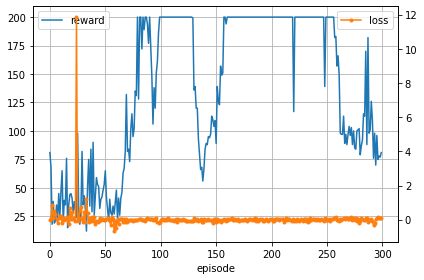

In [15]:
drawHistory(history_rewards, history_metrics)

In [17]:
def sample_action(state):
    action, _ = model.sample_action(state)
    return action
testEnv(env, sample_action)

0, step: 82, reward: 82.0
1, step: 73, reward: 73.0
2, step: 79, reward: 79.0
3, step: 82, reward: 82.0
4, step: 75, reward: 75.0
